# Prediction of CO2 Emission per Country
## Pappo, Katz, Pimenta Silva, Tuncel

### Importing and Downloading

In [20]:
import numpy as np
import pandas as pd

In [73]:
df_CO2_brut = pd.read_csv('data/GCB2022v27_MtCo2_flat.csv')
# df_CO2

In [74]:
df_GEI_brut = pd.read_csv('data/Global Economy Indicators.csv')
# df_GEI_brut

### Cleaning the datasets

In [281]:
# Drop rows where year is less than 1970
df_CO2 = df_CO2_brut.drop(df_CO2_brut[df_CO2_brut['Year'] < 1970].index)

df_CO2 = df_CO2.drop(columns=['ISO 3166-1 alpha-3'])

# Replace NaN values with 0
df_CO2 = df_CO2.replace(np.nan, 0)

# Delete spaces in column names
df_CO2.columns = df_CO2.columns.str.strip()

df_CO2['Country'] = df_CO2['Country'].replace({'USA': 'United States of America'})
df_CO2['Country'] = df_CO2['Country'].replace({'Democratic Republic of the Congo': 'Democratic Republic of Congo'})

df_CO2.reset_index(drop=True, inplace=True)
# df_CO2.head()

In [280]:
# Drop columns that are not needed
df_GEI = df_GEI_brut.drop(columns=[
    ' Currency ',
    ' AMA exchange rate ', 
    ' IMF based exchange rate ', 
    ' Changes in inventories ', 
    ' Other Activities (ISIC J-P) '])

# Delete spaces in column names
df_GEI.columns = df_GEI.columns.str.strip()

# Delete spaces in Country names
df_GEI['Country'] = df_GEI['Country'].str.strip()

df_GEI['Country'] = df_GEI['Country'].replace({'United States': 'United States of America'})
df_GEI['Country'] = df_GEI['Country'].replace({'D.R. of the Congo': 'Democratic Republic of Congo'})
df_GEI['Country'] = df_GEI['Country'].replace({'Russian Federation': 'Russia'})

df_GEI.reset_index(drop=True, inplace=True)

# Rename columns
df_GEI.rename(columns={
    'Agriculture, hunting, forestry, fishing (ISIC A-B)': 'Agriculture & Fishing',
    'Construction (ISIC F)': 'Construction',
    'Exports of goods and services': 'Exports',
    'Final consumption expenditure': 'Final Consumption',
    'General government final consumption expenditure': 'Gov. Consumption',
    'Gross capital formation': 'Gross Capital Formation',
    'Gross fixed capital formation (including Acquisitions less disposals of valuables)': 'Gross Fixed Capital',
    'Household consumption expenditure (including Non-profit institutions serving households)': 'Household Consumption',
    'Imports of goods and services': 'Imports',
    'Manufacturing (ISIC D)': 'Manufacturing',
    'Mining, Manufacturing, Utilities (ISIC C-E)': 'Mining & Utilities',
    'Total Value Added': 'Total Value Added',
    'Transport, storage and communication (ISIC I)': 'Transport & Comm.',
    'Wholesale, retail trade, restaurants and hotels (ISIC G-H)': 'Wholesale & Retail',
    'Gross National Income(GNI) in USD': 'GNI (USD)',
    'Gross Domestic Product (GDP)': 'GDP',
    'Total': 'Total'
}, inplace=True)

# df_GEI.head()

### Merging Datasets

In [278]:
# Merge the two dataframes on 'Country' and 'Year'
df = df_GEI.merge(df_CO2, on=['Country', 'Year'])

df.head()

,CountryID,Country,Year,Population,Per capita GNI,Agriculture & Fishing,Construction,Exports,Final Consumption,Gov. Consumption,...,GNI (USD),GDP,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
0,4,Afghanistan,1970,10752971,164,8.699174e+08,46793902.0,165618722.0,1.663221e+09,112126986.0,...,1.766528e+09,1.731436e+09,1.670397,0.436974,0.671986,0.216651,0.047350,0.297436,0.0,0.155343
1,4,Afghanistan,1971,11015857,168,9.108281e+08,48994113.0,193580300.0,1.796541e+09,121114833.0,...,1.850122e+09,1.812838e+09,1.893554,0.359072,0.747456,0.439680,0.043234,0.304112,0.0,0.171893
2,4,Afghanistan,1972,11286753,149,8.279453e+08,44535223.0,227654380.0,1.607159e+09,108347543.0,...,1.683948e+09,1.647900e+09,1.530347,0.190528,0.626544,0.300448,0.046427,0.366400,0.0,0.135588
3,4,Afghanistan,1973,11575305,150,8.554869e+08,46018542.0,226913554.0,1.617037e+09,109013455.0,...,1.739998e+09,1.702716e+09,1.635454,0.310745,0.701918,0.332680,0.067106,0.223005,0.0,0.141288
4,4,Afghanistan,1974,11869879,177,1.035913e+09,55721659.0,284938449.0,1.907408e+09,128588961.0,...,2.106420e+09,2.061729e+09,1.913152,0.304695,0.770914,0.400141,0.070301,0.367102,0.0,0.161177


### Vizualisation

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_corr = df[[
    'Agriculture & Fishing',
    'Construction',
    'Exports',
    'Final Consumption',
    'Gov. Consumption',
    'Gross Fixed Capital',
    'Household Consumption',
    'Imports', 
    'Manufacturing',
    'Mining & Utilities', 
    'Transport & Comm.',
    'Wholesale & Retail',
    'GNI (USD)', 
    'Total']].corr()

plt.figure(figsize=(10, 8))  # Définir la taille de la figure
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
df_total = df[['Year', 'Total']].groupby('Year').sum().reset_index()

plt.figure(figsize=(5, 4))  # Définir la taille de la figure
plt.plot(df_total['Year'], df_total['Total'], label='Total CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Mt)')
plt.title('Total CO2 Emissions')
plt.show() 

In [ ]:
# Group by year and sum the production for each sector and countries
df_prod = df.groupby('Year')[
    ['Agriculture & Fishing', 'Construction', 'Household Consumption', 
     'Manufacturing', 'Mining & Utilities', 'Transport & Comm.', 'Wholesale & Retail']
].sum().reset_index()

# List of sectors
sectors = ['Agriculture & Fishing', 'Construction', 'Household Consumption', 
           'Manufacturing', 'Mining & Utilities', 'Transport & Comm.', 'Wholesale & Retail']

plt.figure(figsize=(8, 6))
for sector in sectors:
    plt.plot(df_prod['Year'], df_prod[sector], label=sector)

plt.xlabel('Year')
plt.ylabel('Production ($)')
plt.title('Production by Sector')
plt.legend()
plt.show()


In [186]:
import geopandas as gpd

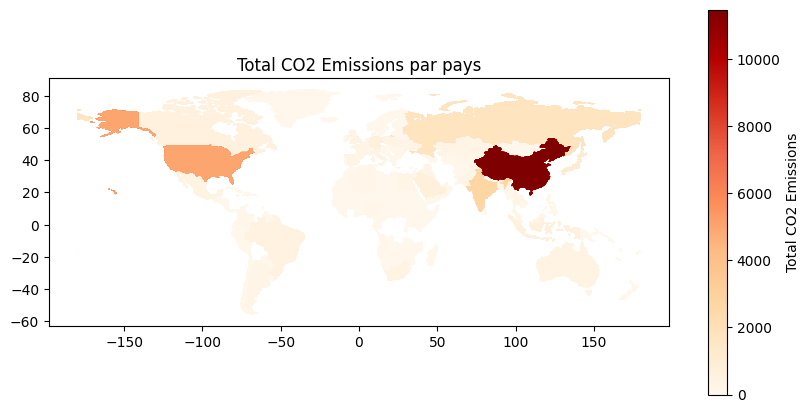

In [279]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

gdf = gpd.read_file(url)

df_world = gdf.merge(df, left_on='ADMIN', right_on='Country')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df_world.plot(column='Total',  # La colonne utilisée pour colorer la carte 
              cmap='OrRd',          # Palette de couleurs
              legend=True,          # Ajouter une légende
              legend_kwds={'label': "Total CO2 Emissions"},
              ax=ax)

ax.set_title('Total CO2 Emissions par pays')
plt.show()